In [71]:
# imports and loading
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import numpy as np
import os
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation

# settings
iM_investigate = 'PurR-1' #'ArgR'
regulator = 'purR' #'argR'
iM_to_metabolite = {
    'ArgR' : 'Arginine',
    'PurR-1' : 'Hypoxanthine',
    'FadR/IclR' : 'AcetylN/ACoA',
    'Crp-1' : 'AcetylN/ACoA',
}
metabolite = iM_to_metabolite[iM_investigate]

# load in a bunch of potentially useful files
# loading merged log_tpm_file
# merge together log_tpm_df files
log_tpm_df = pd.read_csv('../data/precise_1.0/log_tpm.csv', index_col = 0)
starve_log_tpm = pd.read_csv('../data/validation_data_sets/stationary_phase/cleaned_log_tpm_qc.csv', index_col = 0)
to_blank_inds = list(set(log_tpm_df.index) - set(starve_log_tpm.index))
# need to create zero rows for missing values
zeros_data = {col : 0 for col in starve_log_tpm.columns}
zeros_df = pd.DataFrame(zeros_data, index = to_blank_inds)
starve_log_tpm = pd.concat([starve_log_tpm, zeros_df])
starve_log_tpm = starve_log_tpm.loc[log_tpm_df.index]
log_tpm_df = pd.concat([starve_log_tpm, log_tpm_df], axis = 1)

iM_to_genes = {}
k_to_iM = {}
f = open('../data/precise_1.0/iM_table.csv', 'r')
lines = f.readlines()
f.close()
k_to_iM = {line.split(',')[0] : line.split(',')[1] for line in lines[1:]}
f = open('../data/precise_1.0/gene_presence_list.csv', 'r')
lines = f.readlines()
f.close()
for line in lines[1:]:
    k = line.split(',')[1]
    iM = k_to_iM[k]
    gene = line.split(',')[2].replace('\n', '')
    if iM not in iM_to_genes:
        iM_to_genes.update({iM : []})
    iM_to_genes[iM].append(gene)

A = pd.read_csv('../data/precise_1.0/A.csv', index_col = 0).rename(index = {int(k) : v for k, v in k_to_iM.items()})
all_A = pd.read_csv('../data/validation_data_sets/merged_A.csv', index_col = 0)

pickle_in = open('../data/b_to_gene.pkl', 'rb')
b_to_gene = pickle.load(pickle_in)
pickle_in.close()
gene_to_b = {v : k for k, v in b_to_gene.items()}
regulator = gene_to_b[regulator]

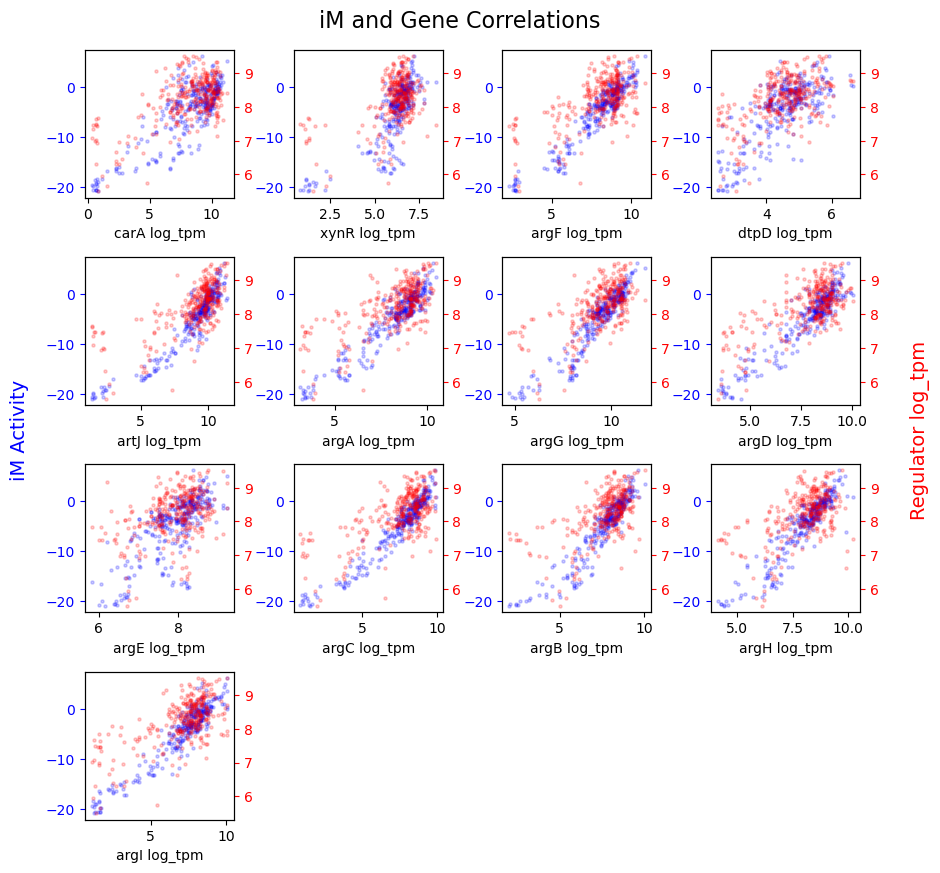

In [25]:
# sanity plotting
genes = iM_to_genes[iM_investigate]
size = int(len(genes)**.5) + 1

# let's plot expression against iM and regulator
fig, axs = plt.subplots(size, size, figsize = (10, 10))
for gene, ax in zip(genes, axs.flatten()):
    ax.scatter(log_tpm_df.loc[gene], all_A.loc[iM_investigate], label = gene, color = 'blue', alpha = 0.2, s = 5)
    #ax.set_ylabel(iM+' iM Activity', color = 'blue')
    ax.tick_params(axis='y', colors = 'blue')
    ax.set_xlabel(b_to_gene[gene]+' log_tpm')
    
    ax2 = ax.twinx()
    ax2.scatter(log_tpm_df.loc[gene], log_tpm_df.loc[regulator], color='r', alpha=0.2, s=5)
    #ax2.set_ylabel('Regulator log_tpm', color = 'r')
    ax2.tick_params(axis='y', colors = 'r')
    
    # Set aspect ratio to be equal
    ax.set(adjustable='datalim', aspect=np.ptp(log_tpm_df.loc[gene])/np.ptp(all_A.loc[iM_investigate]))
    ax2.set(adjustable='datalim', aspect=np.ptp(log_tpm_df.loc[gene])/np.ptp(log_tpm_df.loc[regulator]))
    
# disappear the other axes
for ax in axs.flatten()[len(genes):]:
    ax.axis('off')

# Add one large label on the right side of all subplots
fig.text(.05, 0.5, 'iM Activity', va='center', color = 'blue', rotation='vertical', fontsize = 14)

# Add one large label on the left side of all subplots
fig.text(.95, 0.5, 'Regulator log_tpm', va='center', color = 'red', rotation='vertical', fontsize = 14)

plt.suptitle('iM and Gene Correlations', fontsize = 16, y = 0.92)
plt.subplots_adjust(wspace=0.4, hspace=0.4)
if not os.path.exists('../figures/'+iM_investigate):
    os.mkdir('../figures/'+iM_investigate)
plt.savefig('../figures/'+iM_investigate+'/iM_regulator_gene_correlations.pdf', transparent = True)
plt.show()

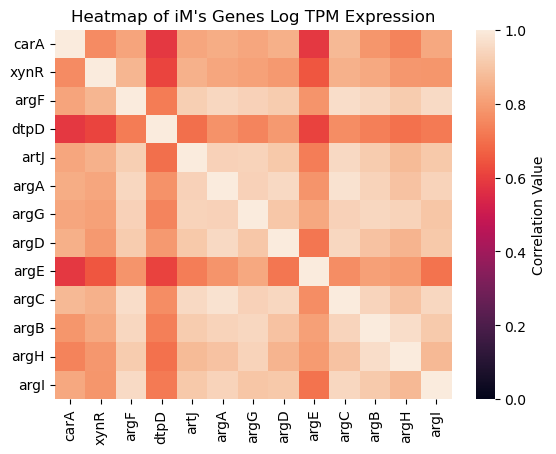

In [26]:
# now let's heatmap the genes
corrs = log_tpm_df.loc[genes].T.corr().rename(columns = b_to_gene, index = b_to_gene)
heat_map = sns.heatmap(corrs, vmin = 0, vmax = 1)
plt.title('Heatmap of iM\'s Genes Log TPM Expression')
color_bar = heat_map.collections[0].colorbar
color_bar.set_label('Correlation Value')
plt.yticks(rotation = 0)
plt.savefig('../figures/'+iM_investigate+'/gene_heatmap.pdf', transparent = True)
plt.show()

/tmp/ipykernel_2845416/3539251189.py:30: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 15


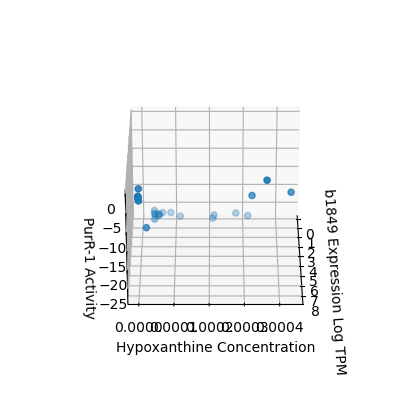

In [72]:
# 3D plot of iModulon, gene expression, and metabolite concentration
gene = iM_to_genes[iM_investigate][5]


starve_metabs = pd.read_csv('../data/validation_data_sets/stationary_phase/cleaned_metabolites_data.csv', index_col = 0)
# above is in (µM) , convert to M
starve_metabs[starve_metabs.columns[1:]] *= 1e-6
starve_log_tpm = pd.read_csv('../data/validation_data_sets/stationary_phase/cleaned_log_tpm_qc.csv', index_col = 0)
starve_cols = list(set(starve_log_tpm.columns).intersection(all_A.columns))

x_vals = list(log_tpm_df[starve_cols].loc[gene].values)
y_vals = list(starve_metabs[starve_cols].loc[metabolite])
z_vals = list(all_A[starve_cols].loc[iM_investigate])


fig = plt.figure(figsize = (4, 4))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

ax.scatter(x_vals, y_vals, z_vals)

ax.set_xlabel(gene+' Expression Log TPM', labelpad = 10)
ax.set_ylabel(metabolite+' Concentration', labelpad = 10)
ax.set_zlabel(iM_investigate+' Activity', labelpad = 10)


# this function defines the animation action done to the plot
def rotate(angle):
    ax.view_init(azim=angle)
    ax.dist = 15

angle = 3
ani = animation.FuncAnimation(fig, rotate, frames=np.arange(0, 360, angle), interval=10)
ani.save('../figures/3D_gene_iM_metabolite_sanity.gif', writer=animation.PillowWriter(fps=10))

/tmp/ipykernel_2845416/116160979.py:28: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 15


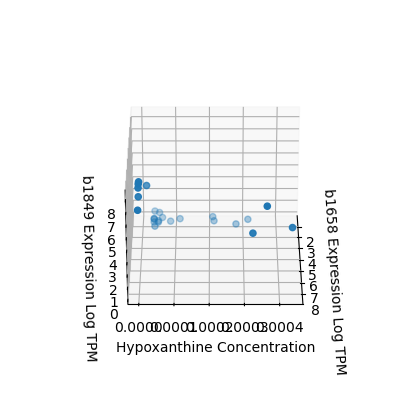

In [73]:
# 3D plot of regulator, gene expression, and metabolite concentration
gene = iM_to_genes[iM_investigate][5]


starve_metabs = pd.read_csv('../data/validation_data_sets/stationary_phase/cleaned_metabolites_data.csv', index_col = 0)
# above is in (µM) , convert to M
starve_metabs[starve_metabs.columns[1:]] *= 1e-6
starve_log_tpm = pd.read_csv('../data/validation_data_sets/stationary_phase/cleaned_log_tpm_qc.csv', index_col = 0)
starve_cols = list(set(starve_log_tpm.columns).intersection(all_A.columns))

x_vals = list(log_tpm_df[starve_cols].loc[regulator].values)
y_vals = list(starve_metabs[starve_cols].loc[metabolite])
z_vals = list(log_tpm_df[starve_cols].loc[gene].values)

fig = plt.figure(figsize = (4, 4))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

ax.scatter(x_vals, y_vals, z_vals)

ax.set_xlabel(regulator+' Expression Log TPM', labelpad = 10)
ax.set_ylabel(metabolite+' Concentration', labelpad = 10)
ax.set_zlabel(gene+' Expression Log TPM', labelpad = 10)

# this function defines the animation action done to the plot
def rotate(angle):
    ax.view_init(azim=angle)
    ax.dist = 15

angle = 3
ani = animation.FuncAnimation(fig, rotate, frames=np.arange(0, 360, angle), interval=10000)
ani.save('../figures/3D_gene_reg_metabolite_sanity.gif', writer=animation.PillowWriter(fps=10))

/tmp/ipykernel_2845416/1380466202.py:30: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 15


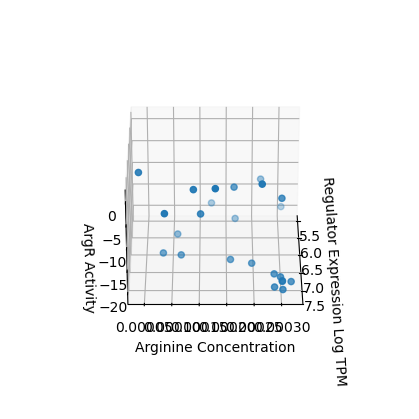

In [63]:
# 3D plot of iModulon, regulator, and metabolite concentration
gene = 'b3237'


starve_metabs = pd.read_csv('../data/validation_data_sets/stationary_phase/cleaned_metabolites_data.csv', index_col = 0)
# above is in (µM) , convert to M
starve_metabs[starve_metabs.columns[1:]] *= 1e-6
starve_log_tpm = pd.read_csv('../data/validation_data_sets/stationary_phase/cleaned_log_tpm_qc.csv', index_col = 0)
starve_cols = list(set(starve_log_tpm.columns).intersection(all_A.columns))

x_vals = list(log_tpm_df[starve_cols].loc[gene].values)
y_vals = list(starve_metabs[starve_cols].loc[metabolite])
z_vals = list(all_A[starve_cols].loc[iM_investigate])


fig = plt.figure(figsize = (4, 4))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

ax.scatter(x_vals, y_vals, z_vals)

ax.set_xlabel('Regulator Expression Log TPM', labelpad = 10)
ax.set_ylabel(metabolite+' Concentration', labelpad = 10)
ax.set_zlabel(iM_investigate+' Activity', labelpad = 10)

# this function defines the animation action done to the plot
def rotate(angle):
    ax.view_init(azim=angle)
    ax.dist = 15

angle = 3
ani = animation.FuncAnimation(fig, rotate, frames=np.arange(0, 360, angle), interval=10)
ani.save('../figures/3D_reg_iM_metabolite_sanity.gif', writer=animation.PillowWriter(fps=10))